In [1]:
import torch
import torch.nn as nn

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cpu


# Annotated Multi-Layer Perceptron (MLP) for Digit Classification (0-9)

This notebook implements a `MLP to classify handwritten digit images from 0 to 9`. The images belong to the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, wherein each image is represented as a matrix comprising 28 x 28 pixels (*white* is stored as 0, *black* as 255, and *shades of gray* in between).

Our goal is to approximate a mathematical model to the data provided by said MNIST dataset. The intuition is to average (weight) each pixel for each of the possible digits, by adjusting said weighting from a random initialization until it approximates to a favorable digit prediction. In this regard, the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that using multiple nonlinear functions enables to approximate complex patterns such as those needed for computer vision. So, as the building block for our model we use first a basic linear function wherein input pixel values are adjusted by matrix multiplication, namely `input_pixels @ weights + bias` (bias allows the output to be shifted by a constant), and then we combine it with `a non-linear function (RELU)` to approximate complex patterns as outlined in the universal approximation theorem. *Note that a series of linear functions would in practice only fit linear data.*

As further suggested by  Arthur Samuel, we will perform said approximation in an automatic manner using [Stocastic Gradient Descend](https://en.wikipedia.org/wiki/Stochastic_gradient_descent):

1. `initialize parameters`.
2. `calculate predictions` on a mini-batch.
3. `calculate the average loss` between the predictions and the targets in the mini-batch.
4. `calculate the gradients`, this provides an indication of how the parameters need to change to minimize the loss function.
5. `step the weights` based on the `gradients` and `learning rate`.
6. repeat from step (ii).
7. stop once a condition is met (e.g. time constraint or based on when the training/validation losses and metrics stop improving).

> *Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience. (Arthur Samuel)*



## 1. Model Definition

For the sake of learning we will implement our own:
- linear layer,
- activation (non-linear) function (RELU),
- sequential layer, 
- flatten layer,
- basic optimizer, and
- learner.

### 1.1 Configuration

In [3]:
from dataclasses import dataclass

@dataclass
class LearnerConfig:
    model: nn.Module
    criterion: nn.Module
    epochs: int
    batch_size: int
    lr: float
    device: str

### 1.2 Linear Layer

In a linear layer, we reduce the dimensionality of the input data. By stacking various linear layers in a later step, the neural network will learn to extract relevant features from the input data.

> Note:
> 
> - the use of **nn.Parameter** to register the linear parameters. This will allow the optimizer, which takes a list of parameters as input, to update the parameter values during backpropagation.
> - the property **requires_grad()** tracks the gradient for a tensor in the `grad` attribute. The gradient is a measure inferred from the derivative of a function that indicates how a function output would change by modifying its parameters. In our case, it tells us how we have to change each weight to make our model better.

In [4]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
    
        self.weight = nn.Parameter((torch.randn((self.in_features,
                                                 self.out_features), device=device) * 0.1).requires_grad_())
        self.bias = nn.Parameter((torch.randn(self.out_features, device=device) * 0.1).requires_grad_())
        """
        step_1: initialize_parameters (weights & biases)
        """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.weight + self.bias
    
    def __repr__(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

### 1.3 RELU function

ReLU stands for rectified linear unit, it is an activation function that converts negative values to 0, while maintaining possitive values. `An activation function introduces non-linearity into the output of a neuron`. Without non-linearity, no matter how many layers our neural network has, it would behave just like a single-layer perceptron, because summing these layers would give us another linear function, preventing the model from learning complex patterns.

In [5]:
class ReLU(nn.Module):
    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        return torch.max(x, torch.tensor(0))

### 1.4 Sequential Layer

We also need a sequential layer to connect the block layers in a feedforward manner from the inputs to the outputs.

In [6]:
class Sequential(nn.Module):
    def __init__(self, *layers):
        super(Sequential, self).__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        layer_str = '\n'.join([f'    ({i}): {layer}' for i, layer in enumerate(self.layers)])
        return f'{self.__class__.__name__}(\n{layer_str}\n)'

### 1.5 Flatten Layer

Since we're working with the MNIST dataset where images need to be flattened we include a `view` transformation. Note that `x.view(x.size(0), -1)` reshapes the x tensor to have a shape of `(x.size(0), N)`. For example, if x is a 3D tensor with shape `(batch_size, height, width)`, `x.view(x.size(0), -1)` would flatten the height, and width dimensions into a single dimension, resulting in a 2D tensor with shape `(batch_size, height*width)`. In our case (batch_size, 28, 28) is reshaped to (batch_size, 784).

In [7]:
class Flatten(nn.Module):
    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        return x.view(x.size(0), -1)

### 1.5 Classifier

By stacking various linear layers in a later step, the neural network will learn to extract relevant features from the input data. Note that as explained above we combine linear and non-linear functions.

In [8]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.main = Sequential(
            Flatten(),
            Linear(in_features=784, out_features=128),
            ReLU(),
            Linear(in_features=128, out_features=64),
            ReLU(),
            Linear(in_features=64, out_features=10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)
        """
        step_2: calculate_predictions
        """

model = DigitClassifier().to(device)
model

DigitClassifier(
  (main): Sequential(
      (0): Flatten()
      (1): in_features=784, out_features=128, bias=True
      (2): ReLU()
      (3): in_features=128, out_features=64, bias=True
      (4): ReLU()
      (5): in_features=64, out_features=10, bias=True
  )
)

Verify that the parameters have been properly registered.

In [9]:
list(model.parameters())[0]

Parameter containing:
tensor([[-0.0261, -0.0317,  0.0396,  ...,  0.0632, -0.1842,  0.0695],
        [ 0.0517, -0.0235,  0.1367,  ...,  0.0189,  0.0350, -0.1229],
        [ 0.1071,  0.1313, -0.0074,  ..., -0.1493,  0.2083, -0.0038],
        ...,
        [-0.0147,  0.0288,  0.0339,  ..., -0.0953, -0.1541,  0.2259],
        [-0.0533, -0.0137,  0.0331,  ...,  0.0015,  0.0739,  0.1074],
        [-0.1288,  0.0720,  0.1954,  ..., -0.1109, -0.0285,  0.0522]],
       requires_grad=True)

### 1.6 Optimizer

Our optimizer adjusts the parameters of the model proportionarly to the gradients computed during backpropagation.

> In 1974, [Paul Werbos](https://ethw.org/Paul_John_Werbos) invented backpropagation for neural networks (Werbos 1974). His development was almost entirely ignored for decades, but [today it is considered the most important foundation of modern AI](https://ieeexplore.ieee.org/author/37344537300).

In [10]:
class BasicOptim:
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr

    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.lr
        """
        step_5: step_weights
        """

    def zero_grad(self):
        for p in self.params:
            p.grad = None
        """
        As PyTorch accumulates gradients. To ensure that the gradients of the current optimization step 
        don't get mixed up with those of the previous steps, we will need to zero them out beforehand.
        """

### 1.7 Init Config

In [11]:
config = LearnerConfig(model=model,
                       criterion=nn.CrossEntropyLoss(),
                       epochs=10, 
                       batch_size=128,
                       lr=0.005,
                       device=device)

## 2. Create DataLoaders

Note the use of `torch.utils.data. DataLoader`, a utility class that helps with batching, shuffling, and loading data in parallel. 

The use of `mini-batches` has several advantages:
- (i) **computational efficiency**: GPUs only performs well if they have lots of work to do at a time,
- (ii) **better generalization**: rather than simply enumerating our dataset in order for every epoch, we randomly shuffle it on every epoch to introduce variance,
- and (iii) **memory usage**: it is a practical choice to not overload GPU's memory with the whole dataset at once.

In [12]:
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader

train_data = datasets.MNIST(root = 'data', train = True, transform = ToTensor(), download = True)
test_data = datasets.MNIST(root = 'data', train = False, transform = ToTensor())
num_workers = 1

loaders = {'train' : DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=num_workers),
           'test'  : DataLoader(test_data, batch_size=config.batch_size, shuffle=False, num_workers=num_workers)}

In [13]:
train_data.data.size(), test_data.data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

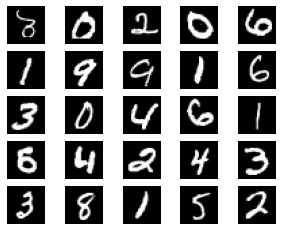

In [14]:
import matplotlib.pyplot as plt 

figure = plt.figure(figsize=(5, 4))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [15]:
img.size()

torch.Size([1, 28, 28])

## 3. Learner: Fit and and Validation

In [16]:
class Learner:
    def __init__(self, config, loaders):
        self.model = config.model
        self.loaders = loaders
        self.optimizer = BasicOptim(model.parameters(), config.lr)
        self.criterion = config.criterion
        self.epochs = config.epochs
        self.device = config.device
                
    def train_epoch(self, epoch):
        epoch_loss = 0.0
        
        for x, y in self.loaders["train"]:
            x, y = x.to(self.device), y.to(self.device)    
            batch_size = x.size(0)

            self.optimizer.zero_grad()
            """
            Without zeroing the gradients, the gradient of the current loss 
            would be added to the previously stored gradient value.
            """
            output = self.model(x)
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()
            """
            steps 2-5: calculate_predictions_loss_gradients + step_params 
            """
            epoch_loss += loss.item() * batch_size
        
        avg_loss = epoch_loss / len(loaders['train'].dataset)
        return avg_loss
        
    def batch_accuracy(self,x, y):
        _, preds = torch.max(x.data, 1)
        return (preds == y).sum().item() / x.size(0)
        """
        Note the use of broadcasting if `predicted` and `y` don't have the same shape.
        """
    
    def validate_epoch(self):
        accs = [self.batch_accuracy(model(x.to(self.device)), 
                                    y.to(self.device)) for x, y in self.loaders["test"]]
        return sum(accs) / len(accs)
        
    def fit(self):
        print('epoch\ttrain_loss\ttest_accuracy')
        for epoch in range(self.epochs):
            epoch_loss = self.train_epoch(epoch)
            epoch_accuracy = self.validate_epoch()
            print(f'{epoch+1}\t{epoch_loss:.6f}\t{epoch_accuracy:.6f}')

    def predict(self, x):
        with torch.no_grad():
            outputs = self.model(x.to(self.device))
            _, predicted = torch.max(outputs.data, 1)
            return predicted
        
    def predict_probs(self, x):
        with torch.no_grad():
            output = self.model(x.to(self.device))
            probabilities = torch.nn.functional.softmax(output, dim=1)
            return probabilities
            
    def export(self, path):
        torch.save(self.model.state_dict(), path)

In [17]:
learner = Learner(config, loaders)

In [18]:
learner.fit()

epoch	train_loss	test_accuracy
1	1.905170	0.670392
2	1.051449	0.804292
3	0.679126	0.845926
4	0.540277	0.862441
5	0.469416	0.879648
6	0.425877	0.889537
7	0.395782	0.896657
8	0.373564	0.900415
9	0.356022	0.904074
10	0.341619	0.906052


## 4. Inference

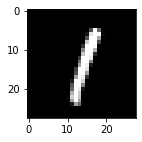

In [19]:
images, _ = next(iter(loaders['test']))

i = torch.randint(len(images), size=(1,)).item()
img = images[i]

plt.figure(figsize=(2, 2))
plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [20]:
learner.predict(img)

tensor([1])

In [21]:
learner.predict_probs(img)

tensor([[7.3276e-06, 9.7975e-01, 3.4301e-03, 5.7157e-03, 7.6313e-05, 2.4152e-04,
         7.4793e-05, 2.4783e-03, 7.3507e-03, 8.7068e-04]])

In [22]:
learner.export('digit_classifier.pt')

----